In [1]:
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(platetools)))
suppressWarnings(suppressPackageStartupMessages(library(gridExtra)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))
suppressWarnings(suppressPackageStartupMessages(library(viridis)))
suppressWarnings(suppressPackageStartupMessages(library(argparse)))    
suppressWarnings(suppressPackageStartupMessages(library(patchwork)))
suppressWarnings(suppressPackageStartupMessages(library(arrow)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))

In [2]:
# generate a platemap plot for the meta data
# read in the platemap data
platemap_df_path <- "../../../data/Interstellar_plate2_platemap.csv"
# aggregate data
PBMC_aggregate_path <- file.path("../../../data/PBMC_preprocessed_sc_norm_aggregated.parquet")
SHSY5Y_aggregate_path <- file.path("../../../data/SHSY5Y_preprocessed_sc_norm_aggregated.parquet")

# read in the platemap data
PBMC_df <- arrow::read_parquet(PBMC_aggregate_path)
SHSY5Y_df <- arrow::read_parquet(SHSY5Y_aggregate_path)
platemap_df <- read.csv(platemap_df_path)
# get the metadata for the PBMC data
PBMC_df <- PBMC_df %>% 
  dplyr::select("Metadata_Well","oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
# get the metadata for the SHSY5Y data
SHSY5Y_df <- SHSY5Y_df %>% 
  dplyr::select("Metadata_Well","oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
# concatenate the two dataframes
df <- rbind(PBMC_df, SHSY5Y_df)
# merge the platemap data with df on the well column
platemap_df1 <- merge(platemap_df, df, by.x = "well_id", by.y = "Metadata_Well", all.x = TRUE)



# if cell_type is blank, set it to "blank"
platemap_df$cell_type[platemap_df$cell_type == ""] <- ""
# if treatment is blank, set it to "blank"
platemap_df$inducer1[platemap_df$inducer1 == ""] <- ""
# replace the "" with ""
platemap_df$inducer2[platemap_df$inducer2 == ""] <- ""
# replace the "" with ""
platemap_df$inhibitor[platemap_df$inhibitor == ""] <- ""
# replace the "" with ""
platemap_df$inhibitor_concentration[platemap_df$inhibitor_concentration == 'NA'] <- ""
platemap_df$inhibitor_concentration[is.na(platemap_df$inhibitor_concentration)] <- ""
platemap_df$inducer2_concentration[is.na(platemap_df$inducer2_concentration)] <- ""
platemap_df$inducer2[is.na(platemap_df$inducer2)] <- ""
# replace the "" with ""
platemap_df$inducer1_concentration[platemap_df$inducer1_concentration == 'NA'] <- ""
platemap_df$inducer2_concentration[platemap_df$inducer2_concentration == 'NA'] <- ""
# replace NA with ""
platemap_df$inducer1_concentration[platemap_df$inducer1_concentration == 'NA'] <- ""

In [3]:

# define save path
platemap_path <- file.path("../figures/")
# make path if it doesn't exist
if (!dir.exists(platemap_path)){
    dir.create(platemap_path)
}

In [4]:
width <- 10
height <- 7
options(repr.plot.width = width, repr.plot.height = height)

In [5]:

# add inducer 1 to inducer 1 concentration
platemap_df$inducer1_conc <- paste(platemap_df$inducer1, platemap_df$inducer1_concentration, platemap_df$inducer1_concentration_unit, sep = " ")
platemap_df$inducer2_conc <- paste(platemap_df$inducer2, platemap_df$inducer2_concentration,platemap_df$inducer2_concentration_unit, sep = " ")
# add inducer1_conc to inducer2_conc if inducer2_conc is not blank
platemap_df$inducer_conc <- ifelse(
    platemap_df$inducer2_conc == '  ',
    platemap_df$inducer1_conc, 
    paste(platemap_df$inducer1_conc, 
    platemap_df$inducer2_conc, 
    sep = " + "))

# add inhibitor to inhibitor concentration
platemap_df$inhibitor_conc <- paste(platemap_df$inhibitor, platemap_df$inhibitor_concentration,platemap_df$inhibitor_concentration_unit, sep = " ")

In [6]:
# replace 'media ctr  µg/ml' with 'media ctr  ug/ml'
platemap_df$inducer_conc[platemap_df$inducer_conc == "media ctr  µg/ml +   "] <- "Media"
platemap_df$inducer_conc[platemap_df$inducer_conc == "media ctr  "] <- "Media"
platemap_df$inducer_conc[platemap_df$inducer_conc == "media ctr  µg/ml"] <- "Media"
platemap_df$inducer_conc[platemap_df$inducer_conc == '  '] <- "Blank"
platemap_df$cell_type[platemap_df$cell_type == ' '] <- "Blank"
# replace 'flagellin 1.000 ' with 'flagellin 1.000 µg/ml
platemap_df$inducer_conc[platemap_df$inducer_conc == "Flagellin 1.000 "] <- "Flagellin 1.000 µg/ml"
# replace disulfiram 2.5µM µM with disulfiram 2.500 µM
platemap_df$inducer_conc[platemap_df$inducer_conc == "Disulfiram 2.5µM µM"] <- "Disulfiram 2.500 µM"

platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == '  '] <- "Blank"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == 'DMSO 0.00025 %'] <- "DMSO 0.025 %"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == 'Media ctr  '] <- "Media"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == 'Media  '] <- "Media"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == 'DMSO 1 %'] <- "DMSO 1.0 %"
unique(platemap_df$inhibitor_conc)
# redefine the values and order
platemap_df$inducer_conc <- factor(
    platemap_df$inducer_conc, 
    levels = c(
    
    'Media',
    'DMSO 0.100 %',

    'LPS 0.010 µg/ml',
    'LPS 0.100 µg/ml',
    'LPS 1.000 µg/ml',
    'LPS 10.000 µg/ml',
    'LPS 100.000 µg/ml',
    'LPS 1.000 µg/ml + Nigericin 1 µM',
    'LPS 1.000 µg/ml + Nigericin 3 µM',
    'LPS 1.000 µg/ml + Nigericin 10 µM',

    'LPS 100.000 µg/ml + Nigericin 1 µM',
    'LPS 100.000 µg/ml + Nigericin 3 µM',
    'LPS 100.000 µg/ml + Nigericin 10 µM',

    'Flagellin 0.100 µg/ml',
    'Flagellin 1.000 µg/ml',

    'Disulfiram 0.100 µM',
    'Disulfiram 1.000 µM',
    'Disulfiram 2.500 µM',

    

    

    'H2O2 100.000 nM',
    'H2O2 100.000 µM',


    'Thapsigargin 1.000 µM',
    'Thapsigargin 10.000 µM',
    
    'Topotecan 5.000 nM',
    'Topotecan 10.000 nM',
    'Topotecan 20.000 nM',
    'Blank'
    )
)

[1] "Blank"             "DMSO 0.025 %"      "Disulfiram 0.1 µM"
[4] "Disulfiram 1 µM"   "Disulfiram 2.5 µM" "Z-VAD-FMK 100 µM" 
[7] "Media"             "DMSO 1.0 %"        "Z-VAD-FMK 30 µM"

In [7]:
# 9 colors
# col 1 - 3 hues
colorgrad1 <- c("white", "grey", "#585858")
# col 2 - 5 hues color ramp 5 hues
colorgrad2 <- colorRampPalette(c("pink", "darkred"))(11)
# col 3 - 3 hues
colorgrad3 <- colorRampPalette(c("yellow", "brown"))(3)
# col 4 - 3 hues
colorgrad4 <- colorRampPalette(c("lightblue", "darkblue"))(6)
# col 5 - 2 hues
colorgrad5 <- colorRampPalette(c("lightgreen", "darkgreen"))(2)
# col 6 - 3 hues
colorgrad6 <- colorRampPalette(c("purple", "#2e004b"))(3)
# col 7 - 2 hues
colorgrad7 <- colorRampPalette(c("cyan", "darkcyan"))(4)
# col 8 - 2 hues
colorgrad8 <- colorRampPalette(c("#ebb676", "darkorange"))(2)
# col 9 - 3 hues
colorgrad9 <- colorRampPalette(c("magenta", "#833b83"))(3)

In [8]:
# define the colors
colors <- c(
    "Blank" = colorgrad1[1],
    "Media" =colorgrad1[2],
    "DMSO 0.100 %" = colorgrad1[3],
    "LPS 0.010 µg/ml" = colorgrad2[1],
    "LPS 0.100 µg/ml" = colorgrad2[2],
    "LPS 1.000 µg/ml" =colorgrad2[3],
    "LPS 10.000 µg/ml" =colorgrad2[4],
    "LPS 100.000 µg/ml" = colorgrad2[5],
    "LPS 1.000 µg/ml + Nigericin 1 µM" = colorgrad2[6],
    "LPS 1.000 µg/ml + Nigericin 3 µM" = colorgrad2[7],
    "LPS 1.000 µg/ml + Nigericin 10 µM" = colorgrad2[8],
    "LPS 100.000 µg/ml + Nigericin 1 µM" = colorgrad2[9],
    "LPS 100.000 µg/ml + Nigericin 3 µM" = colorgrad2[10],
    "LPS 100.000 µg/ml + Nigericin 10 µM" = colorgrad2[11],
    "Flagellin 0.100 µg/ml" = colorgrad5[1],
    "Flagellin 1.000 µg/ml" = colorgrad5[2],
    "Disulfiram 0.100 µM" = colorgrad4[3],
    "Disulfiram 1.000 µM" = colorgrad4[4],
    "Disulfiram 2.500 µM" = colorgrad4[5],
    "H2O2 100.000 nM" = colorgrad7[1],
    "H2O2 100.000 µM" = colorgrad7[2],
    "Thapsigargin 1.000 µM" = colorgrad8[1],
    "Thapsigargin 10.000 µM" = colorgrad8[2],
    "Topotecan 5.000 nM" = colorgrad9[1],
    "Topotecan 10.000 nM" = colorgrad9[2],
    "Topotecan 20.000 nM" = colorgrad9[3]
)


Warning message:
“Removed 76 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 76 rows containing missing values (`geom_point()`).”


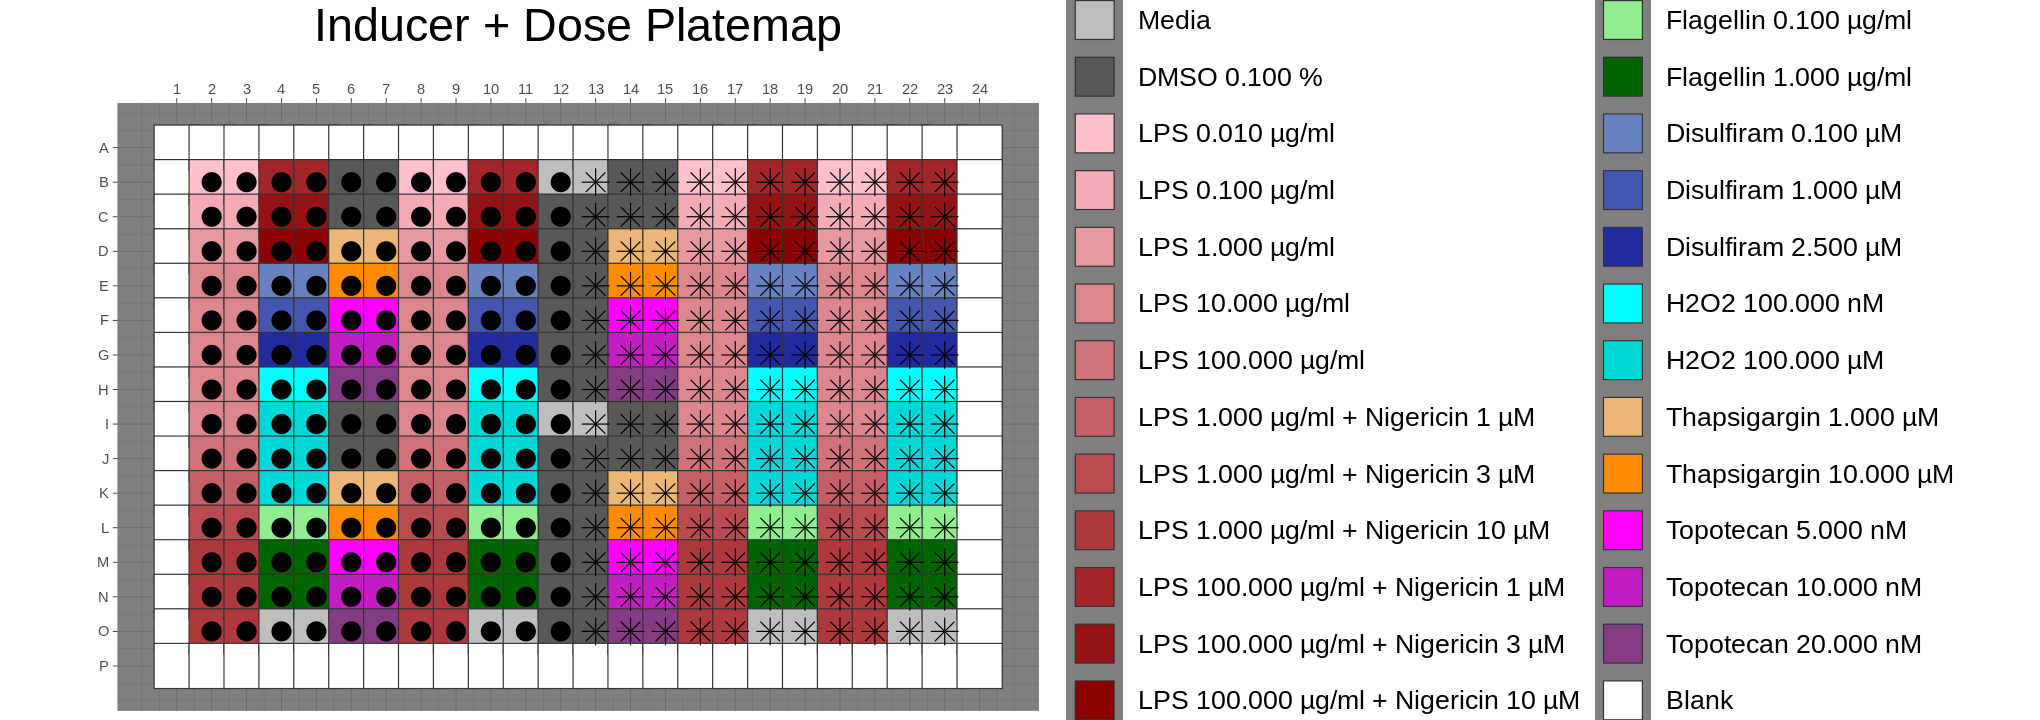

In [9]:
# define pallete
# viridis colors
viridis_pal_custom <- viridis::viridis_pal(option = 'C')(20)

width <- 17
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
inducer_well_dose_platemap <- file.path(paste0(platemap_path,"inducer_well_dose_platemap.png"))
# if path does not exist, create it
platemap_plot_inducer_dose <- (
    raw_map(
        data = platemap_df$inducer_conc,
        well = platemap_df$well_id,
        plate = 384,
        size = 14)
    + theme_dark() 
    # fill the color by dose
    + ggplot2::geom_point(
            aes(shape = platemap_df$cell_type),
            size = 5
            )
       

        + labs(fill = "Inducer + Dose", shape = "Cell Type")
        # remove shape legend from plot
        + guides(fill = guide_legend(override.aes = list(size = 12),ncol = 2))
        + guides(shape = guide_legend(override.aes = list(size = 12),nrow = 1))
        + theme(
            legend.title = element_text(size = 18,hjust = 0.5),
            legend.text = element_text(size = 16)
        )
        # make the blank well grey
        + scale_fill_manual(
            values = colors
            )
        # change the shape of the blank well
        + scale_shape_manual(
            values = c(
                'Blank' = 0,
                'PBMC' = 19,
                'SH-SY5Y' = 8
            )
        )
        # make shape legend horizontal
        # title
    + ggtitle("Inducer + Dose Platemap")
    + theme(plot.title = element_text(size = 28, hjust = 0.5))
    
)
ggsave(inducer_well_dose_platemap, platemap_plot_inducer_dose, width=8, height=8, dpi=500)
platemap_plot_inducer_dose


In [10]:
# replace 'media ctr  µg/ml' with 'media ctr  ug/ml'
platemap_df$inhibitor[platemap_df$inhibitor == "Media ctr"] <- "Media"
platemap_df$inhibitor[platemap_df$inhibitor == " "] <- "Blank"

In [11]:
# create a new column that is the combination of inducer and inducer concentration
platemap_df$inhibitor_conc <- paste0(platemap_df$inhibitor, " ", platemap_df$inhibitor_concentration, " ",  platemap_df$inhibitor_concentration_unit)
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == " "] <- "Blank"


In [12]:
viridis_pal_custom <- viridis::viridis_pal(option = "C")(7)

In [13]:
# replace 'media ctr  µg/ml' with 'media ctr  ug/ml'
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == "Media ctr NA "] <- "media ctr"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == "Media NA "] <- "Media ctr"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == " "] <- "Blank"

platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == ""] <- "Blank"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == '  '] <- "Blank"
platemap_df$cell_type[platemap_df$cell_type == ""] <- "Blank"
# replace  'DMSO 0.00025 %' with 'DMSO 0.025 %'
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == "DMSO 0.00025 %"] <- "DMSO 0.025 %"
unique(platemap_df$inhibitor_conc)
# make the inhibitor_conc a factor
platemap_df$inhibitor_conc <- factor(
    platemap_df$inhibitor_conc, 
    levels = c(
    'Blank',
    'Media  ',
    'DMSO 0.025 %',
    'DMSO 1 %',
    'Disulfiram 0.1 µM',
    'Disulfiram 1 µM',
    'Disulfiram 2.5 µM',
    'Z-VAD-FMK 30 µM',
    'Z-VAD-FMK 100 µM'
    )
)



[1] "Blank"             "DMSO 0.025 %"      "Disulfiram 0.1 µM"
[4] "Disulfiram 1 µM"   "Disulfiram 2.5 µM" "Z-VAD-FMK 100 µM" 
[7] "Media  "           "DMSO 1 %"          "Z-VAD-FMK 30 µM"

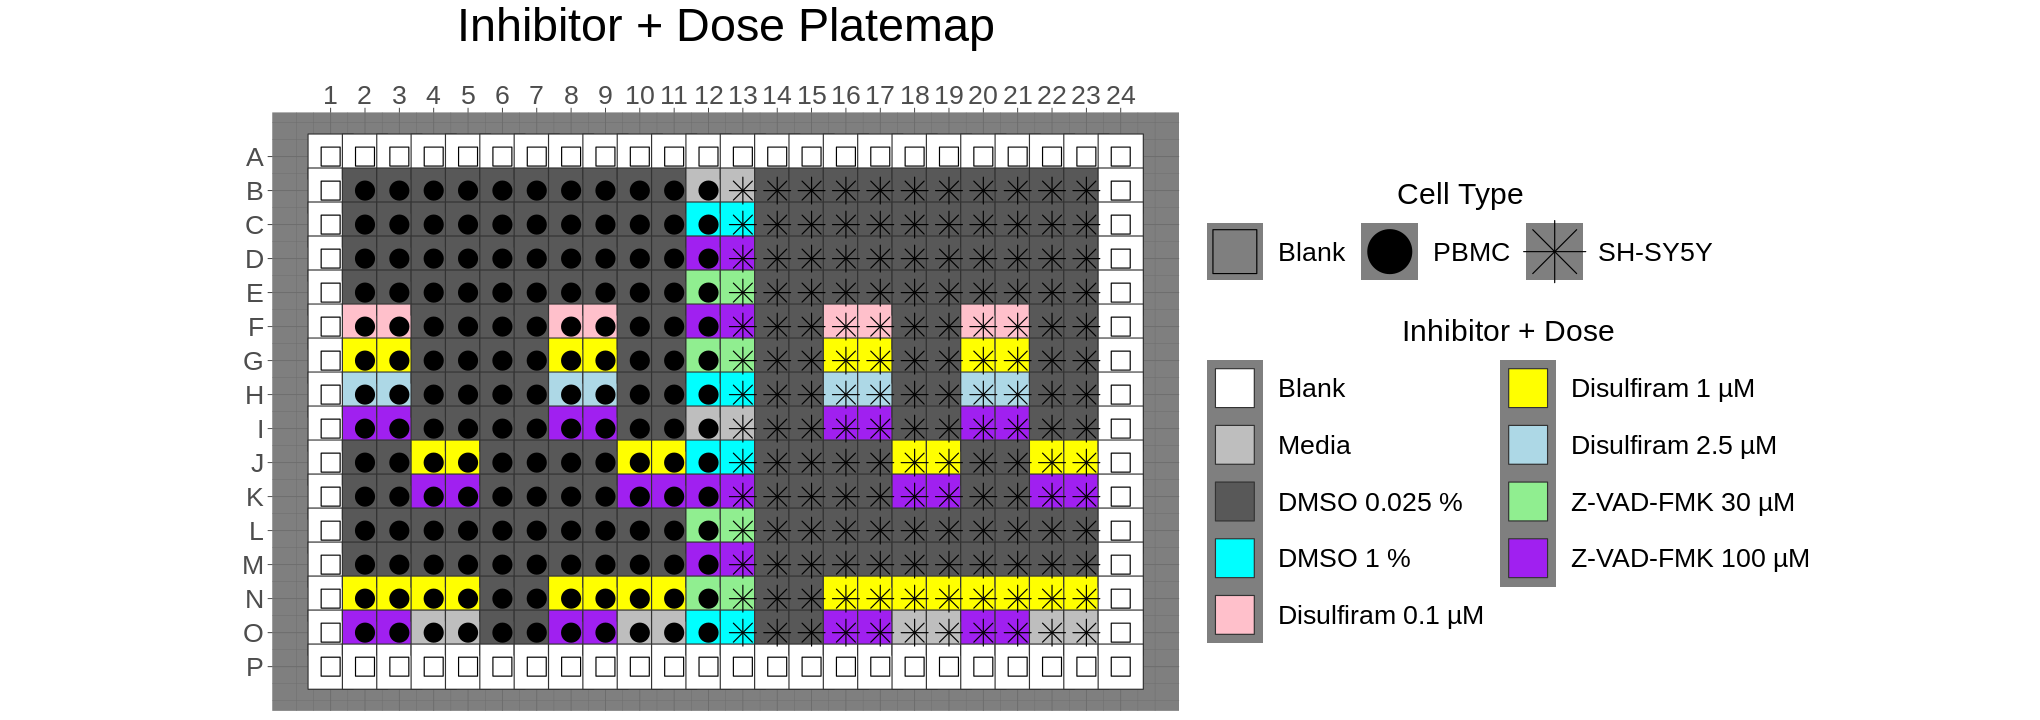

In [14]:
width <- 17
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
inhibtor_well_dose_platemap <- file.path(paste0(platemap_path,"inhibtor_well_dose_platemap.png"))
# if path does not exist, create it
platemap_plot_inhibitor_dose <- (
    raw_map(
        data = platemap_df$inhibitor_conc,
        well = platemap_df$well_id,
        plate = 384,
        size = 14)
    + theme_dark() 
    # fill the color by dose
    + ggplot2::geom_point(
        aes(shape = platemap_df$cell_type),
        size = 5
        )
        # change the size of the shapes in the legend and plot
    # 2 column legend
    + labs(fill = "Inhibitor + Dose", shape = "Cell Type")
    # change legend text size for fill
    
    + guides(shape = guide_legend(override.aes = list(size = 12), nrow = 1))
    + guides(fill = guide_legend(override.aes = list(size = 12),ncol = 2))
    + theme(
        legend.title = element_text(size = 18,hjust = 0.5),
        legend.text = element_text(size = 16),
    )
    # make the blank well grey
        + scale_fill_manual(
            values = c(
                'Blank' = colorgrad1[1],
                'Media  ' = colorgrad1[2],
                'DMSO 0.025 %' = colorgrad1[3],
                'DMSO 1 %' = colorgrad7[1],
                'Disulfiram 0.1 µM' = colorgrad2[1],
                'Disulfiram 1 µM' = colorgrad3[1],
                'Disulfiram 2.5 µM' = colorgrad4[1],
                'Z-VAD-FMK 30 µM' = colorgrad5[1],
                'Z-VAD-FMK 100 µM' = colorgrad6[1]
            )
        )
        # change the shape of the blank well
        + scale_shape_manual(
            values = c(
                'Blank' = 0,
                'PBMC' = 19,
                'SH-SY5Y' = 8
            )
        )
    # x axis ticks larger
    + theme(
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16)
    )
    # title
    + ggtitle("Inhibitor + Dose Platemap")
    + theme(plot.title = element_text(size = 28, hjust = 0.5))
    
)
ggsave(inhibtor_well_dose_platemap, platemap_plot_inhibitor_dose, width=width, height=height, dpi=600)
platemap_plot_inhibitor_dose 


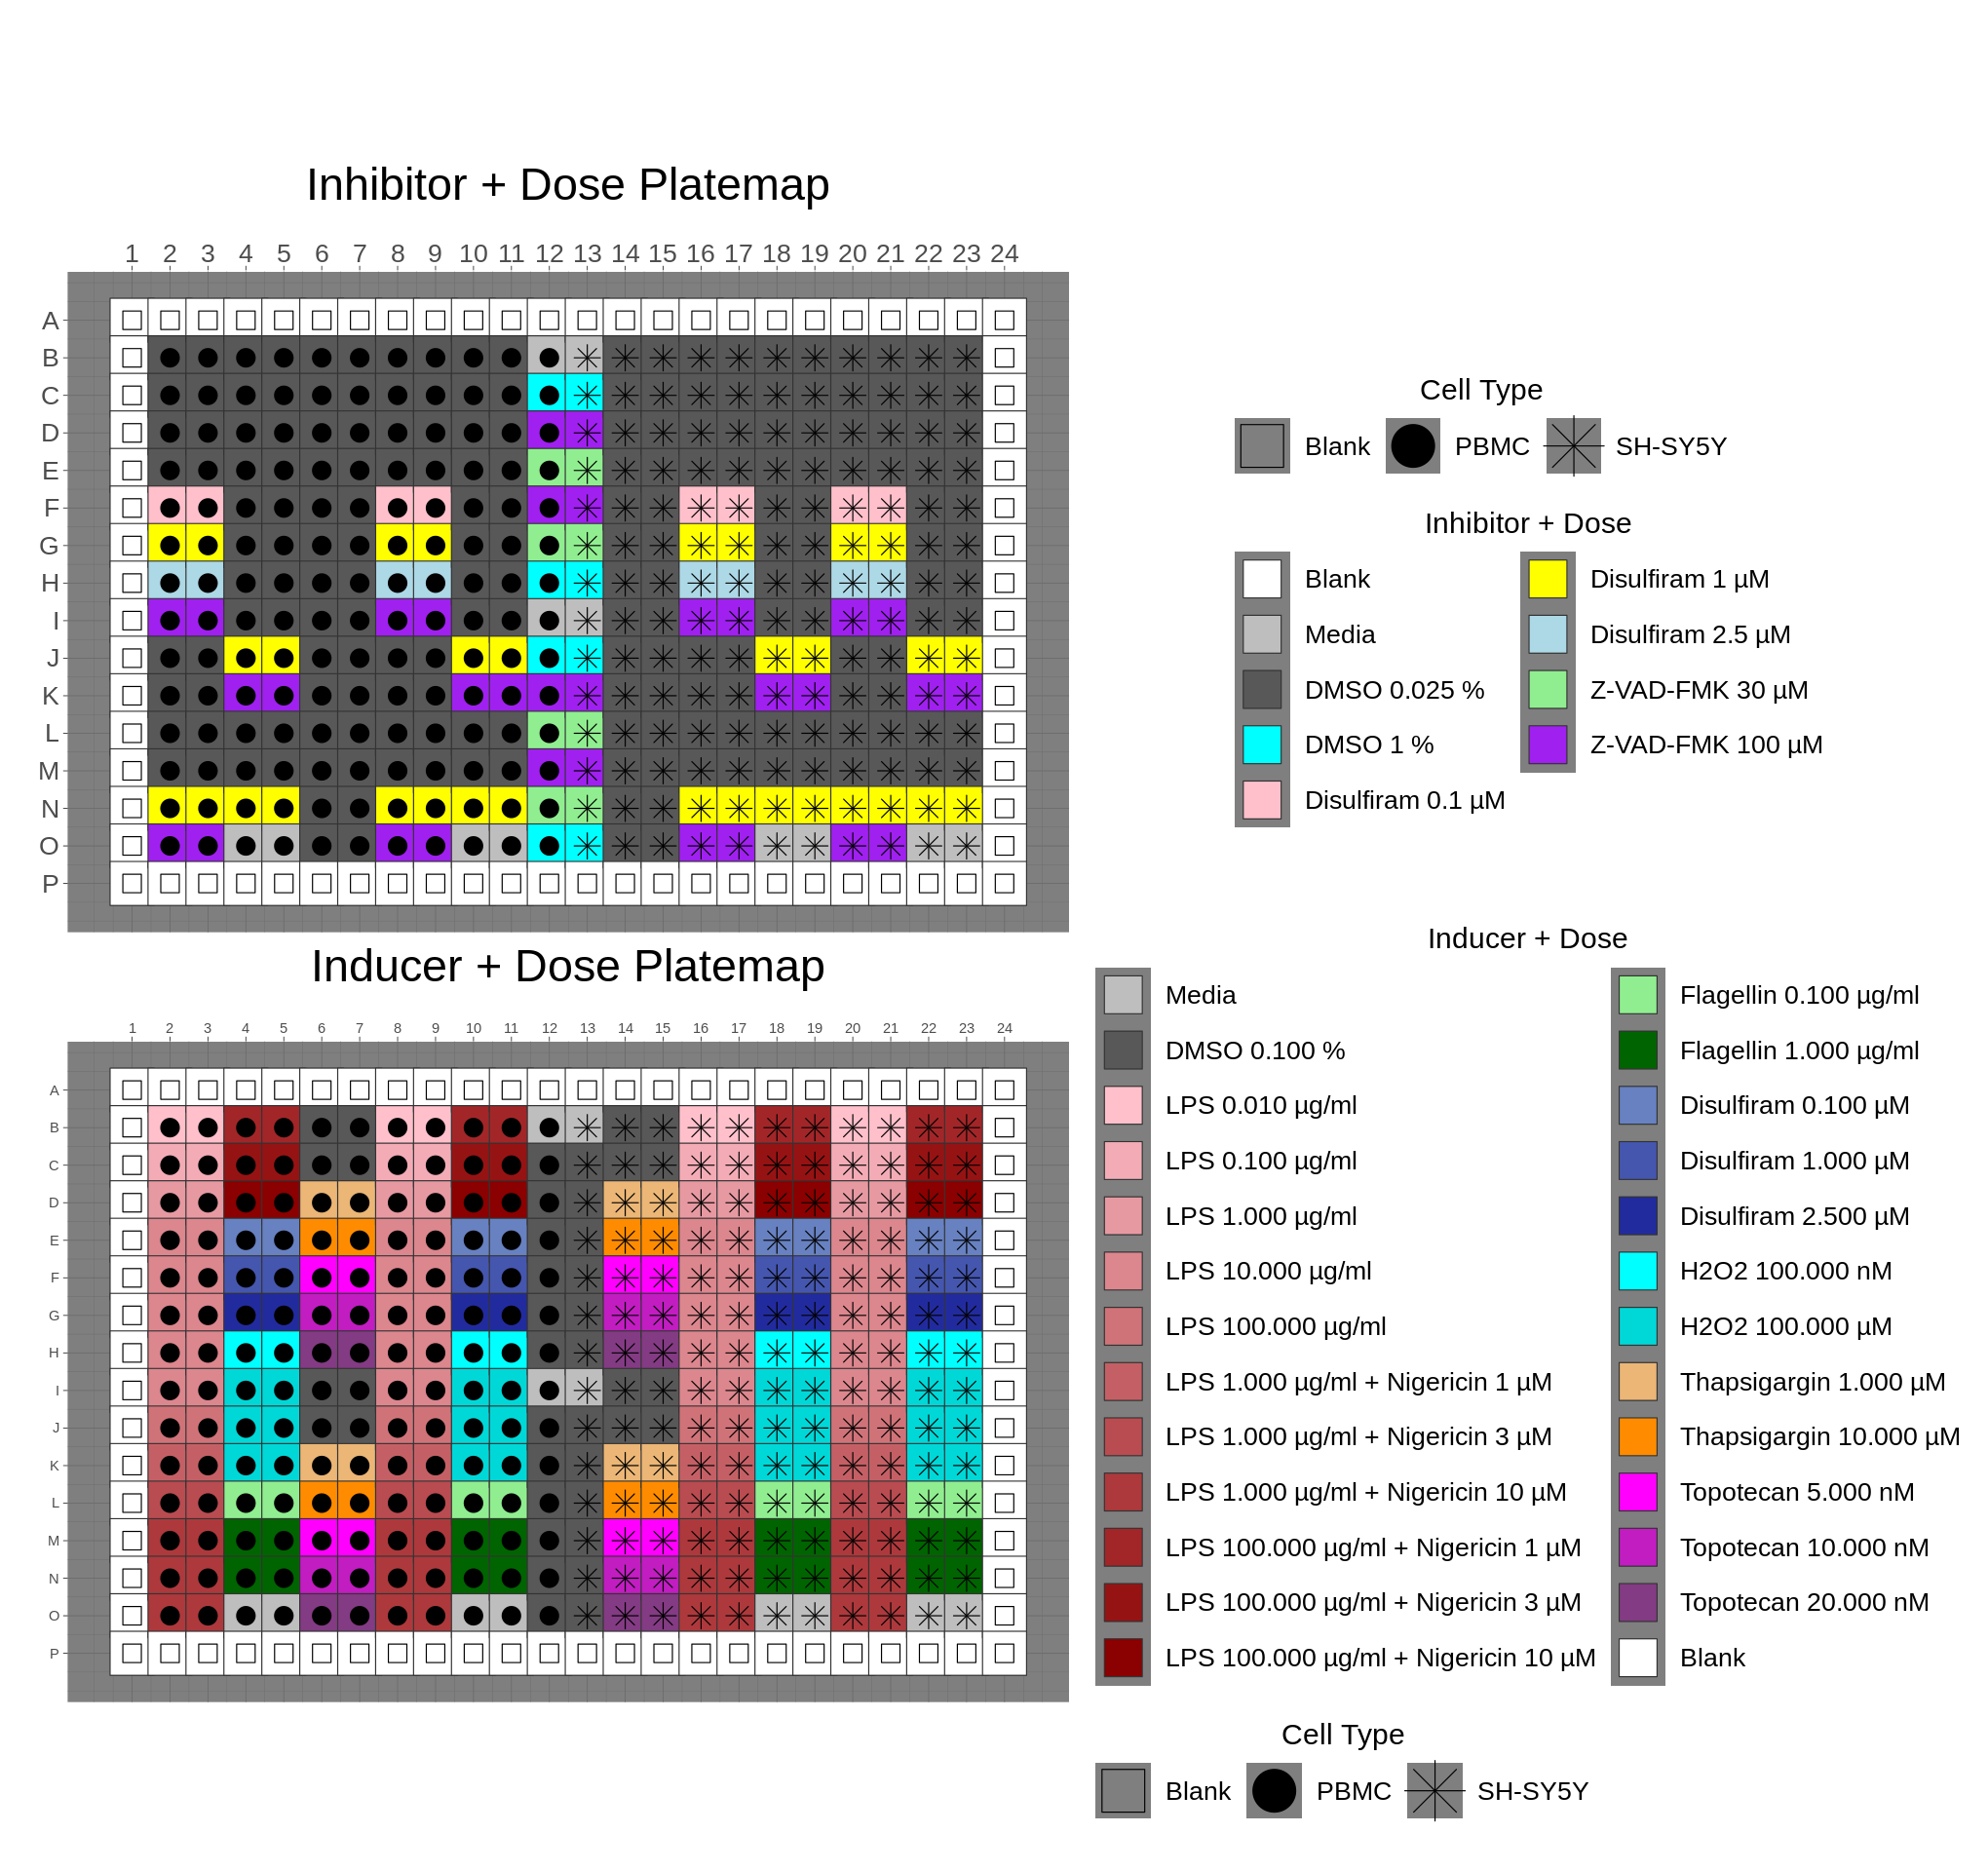

In [15]:
# pathwork for platemaps
width <- 17
height <- 16
options(repr.plot.width = width, repr.plot.height = height)

layout <- c(
    area(t=1, b=1, l=1, r=1),
    area(t=2, b=2, l=1, r=1)
)

patch_plot <- (
    platemap_plot_inhibitor_dose
    + platemap_plot_inducer_dose
    + plot_layout(design = layout)
)
patch_plot
# set save path for patchwork plot
patchwork_platemap_path <- file.path(paste0(platemap_path,"figureS2.png"))
ggsave(patchwork_platemap_path, patch_plot, width=width, height=height, dpi=600)